In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
n = 100 # numero de pontos

# tensão lida
vt = 127 # Tensão CC
erroVt = np.random.rand(1,n) #Variação da leitura
Vt = vt+erroVt # Tensão de leitura

# corrente lida
ia = np.linspace(0,5,n)
erroia = 0.1*(np.random.rand(1,n)) #Variação da leitura
Ia = ia+erroia # Corrente de leitura

# velocidade lida
w = np.linspace(0,188.4,n)
errow = (np.random.rand(1,n)) #Variação da leitura
W = w+errow

# Resistencia da armadura
Ra = 0.1

# Tensão da Armadura
Ea = Vt-Ra*Ia

# KPhi
KPhi = Ea/W

# Torque
T = (Ea*Ia)/W


m = np.matrix([Vt[0], Ia[0], W[0], Ea[0], KPhi[0], T[0]])
m = m.T


In [3]:
# Cria um dataframe com os dados 
df = pd.DataFrame(m, columns = ['Vt', 'Ia', 'W', 'Ea', 'KPhi', 'T'])
df.head()

,Vt,Ia,W,Ea,KPhi,T
0,127.723573,0.055817,0.748916,127.717992,170.537100,9.518914
1,127.037709,0.127550,2.806323,127.024954,45.263840,5.773397
2,127.409394,0.151683,4.207563,127.394226,30.277435,4.592580
3,127.561588,0.182904,6.103134,127.543297,20.898000,3.822324
4,127.417028,0.298337,8.454982,127.387194,15.066525,4.494904


In [4]:
dataset = df.copy()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:
train_dataset.head()

,Vt,Ia,W,Ea,KPhi,T
26,127.412601,1.382408,50.183269,127.274361,2.536191,3.506051
86,127.072313,4.401903,163.823151,126.632123,0.772981,3.402585
2,127.409394,0.151683,4.207563,127.394226,30.277435,4.592580
55,127.387687,2.868314,105.099962,127.100856,1.209333,3.468747
75,127.149178,3.798519,143.011469,126.769326,0.886428,3.367112


In [6]:
test_dataset.head()

,Vt,Ia,W,Ea,KPhi,T
9,127.559966,0.496676,17.214747,127.510298,7.407039,3.678901
12,127.704295,0.665010,23.349660,127.637794,5.466366,3.635190
21,127.490214,1.061328,40.095613,127.384082,3.177008,3.371846
25,127.908776,1.298157,47.656959,127.778960,2.681224,3.480650
36,127.696398,1.883268,68.754852,127.508072,1.854532,3.492580


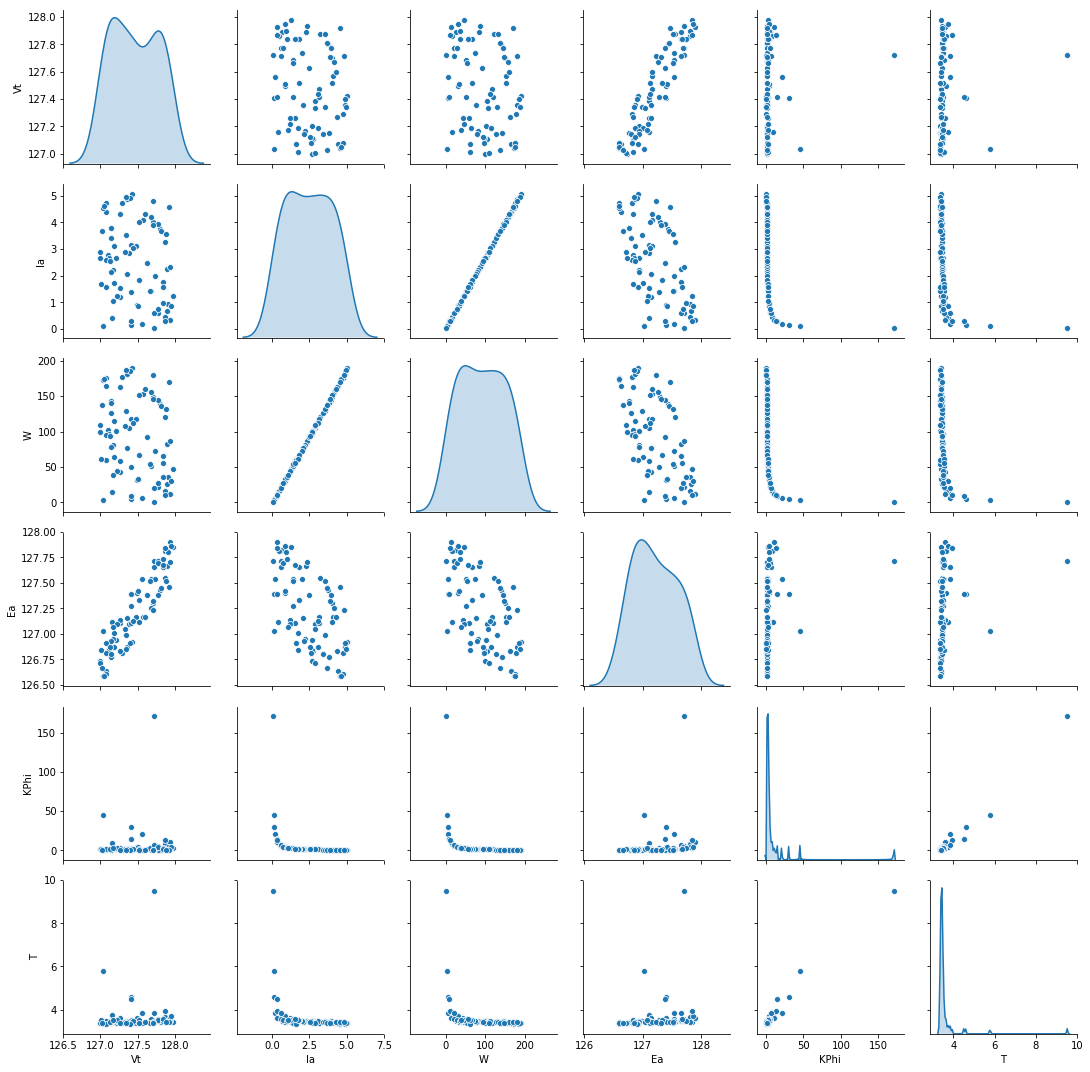

In [7]:
sns.pairplot(train_dataset[["Vt","Ia", "W", "Ea","KPhi","T"]], diag_kind="kde")

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("T")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Vt,80.0,127.466562,0.306394,127.000008,127.172729,127.419614,127.744879,127.976256
Ia,80.0,2.501682,1.498770,0.055817,1.226389,2.570277,3.794786,5.047103
W,80.0,92.721542,56.549226,0.748916,44.053953,94.735686,141.511457,189.223839
Ea,80.0,127.216393,0.370406,126.587927,126.898917,127.156178,127.525690,127.897678
KPhi,80.0,5.601907,19.801125,0.670727,0.895856,1.338967,2.886452,170.537100


In [9]:
train_labels = train_dataset.pop('T')
test_labels = test_dataset.pop('T')

In [10]:
train_labels.head()

26    3.506051
86    3.402585
2     4.592580
55    3.468747
75    3.367112
Name: T, dtype: float64

In [11]:
test_labels.head()

9     3.678901
12    3.635190
21    3.371846
25    3.480650
36    3.492580
Name: T, dtype: float64

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
normed_train_data.head()

,Vt,Ia,W,Ea,KPhi
26,-0.176114,-0.746795,-0.752234,0.156496,-0.154825
86,-1.286737,1.267854,1.257340,-1.577380,-0.243871
2,-0.186580,-1.567952,-1.565255,0.480103,1.246168
55,-0.257428,0.244622,0.218896,-0.311922,-0.221835
75,-1.035868,0.865268,0.889312,-1.206967,-0.238142


In [14]:
normed_test_data.head()

,Vt,Ia,W,Ea,KPhi
9,0.304850,-1.337768,-1.335240,0.793467,0.091163
12,0.775907,-1.225453,-1.226752,1.137673,-0.006845
21,0.077197,-0.961025,-0.930622,0.452715,-0.122463
25,1.443287,-0.803009,-0.796909,1.518786,-0.147501
36,0.750135,-0.412615,-0.423820,0.787456,-0.189251


In [15]:
def build_model():
  model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(25, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = build_model()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
...................................................................................................

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


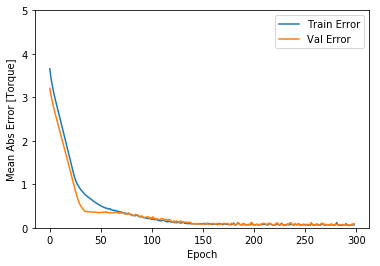

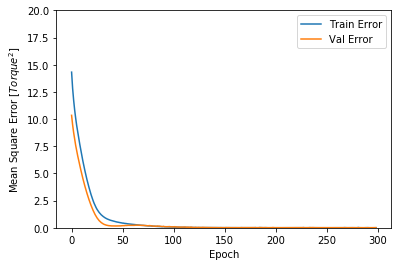

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Torque]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Torque^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
   


plot_history(history)

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Torque".format(mae))

1/1 - 0s - loss: 0.0175 - mae: 0.0985 - mse: 0.0175
Testing set Mean Abs Error:  0.10 Torque


In [20]:
test_predictions = model.predict(normed_test_data).flatten()

In [21]:
test_predictions-test_labels

9     0.193844
12    0.065987
21    0.217965
25    0.014901
36    0.009258
37    0.074921
39    0.038650
44    0.128054
46   -0.033518
47    0.020675
58    0.146907
64    0.047324
65    0.099271
67   -0.063762
70    0.220758
81    0.063114
83   -0.013035
87    0.359530
88    0.108860
96    0.050326
Name: T, dtype: float64

In [22]:
m2 = np.matrix([Vt[0], Ia[0], W[0], Ea[0], KPhi[0]])
m2 = m2.T

In [23]:
df2 = pd.DataFrame(m2, columns = ['Vt', 'Ia', 'W', 'Ea', 'KPhi'])
df2.head()

,Vt,Ia,W,Ea,KPhi
0,127.723573,0.055817,0.748916,127.717992,170.537100
1,127.037709,0.127550,2.806323,127.024954,45.263840
2,127.409394,0.151683,4.207563,127.394226,30.277435
3,127.561588,0.182904,6.103134,127.543297,20.898000
4,127.417028,0.298337,8.454982,127.387194,15.066525


In [43]:
normdf = norm(df2)
print(normdf)

          Vt        Ia         W        Ea      KPhi
0   0.838828 -1.631915 -1.626417  1.354186  8.329587
1  -1.399676 -1.584054 -1.590034 -0.516836  2.003014
2  -0.186580 -1.567952 -1.565255  0.480103  1.246168
3   0.310144 -1.547121 -1.531735  0.882557  0.772486
4  -0.161666 -1.470103 -1.490145  0.461119  0.477984
..       ...       ...       ...       ...       ...
95 -0.354608  1.583960  1.564378 -0.934243 -0.247546
96 -0.596272  1.618052  1.593004 -1.147938 -0.247881
97 -0.225868  1.600764  1.635336 -0.834551 -0.248302
98 -0.405763  1.639808  1.659923 -0.999155 -0.248576
99 -0.144785  1.698340  1.706518 -0.806963 -0.249035

[100 rows x 5 columns]


In [25]:
test_predictions = model.predict(normdf).flatten()

In [26]:
td = np.array(test_predictions)

(3, 5)

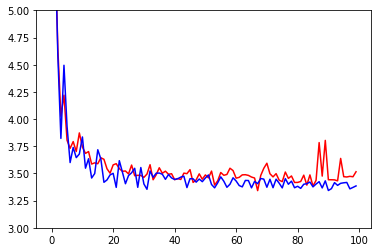

In [53]:
plt.plot(td,'r')
plt.plot(T[0],'b')
plt.ylim([3,5])

In [50]:
medidas = np.matrix([127.5, 0.1, 8, 127.1, 30])

df3 = pd.DataFrame(medidas, columns = ['Vt', 'Ia', 'W', 'Ea', 'KPhi'])

MedNorm = norm(df3)
print(MedNorm)


torque_pred = model.predict(MedNorm).flatten()
print(torque_pred)

         Vt        Ia         W        Ea      KPhi
0  0.109135 -1.602436 -1.498191 -0.314232  1.232157
[4.6657033]
